# topic modeling pipeline

This notebook will walk you through:
1. data reterival from SQL database
2. Pre-processing data
3. Running topic modeling (different models)
4. post processing (including showing topics, topic-doc distribution, etc.)
5. Storing results into DB

# imports

In [1]:
from pre_processing import remove_html_tags, preprocess_data, prepare_corpus
from post_processing import topic_selection, date2days
from rpy2 import robjects #loading R inside Python
#importing functions to read pandas DF
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

import pandas as pd

import numpy as np

import os

#import R base library
base = importr('base')

mallet_path = 'mallet' #'mallet for mac-os

[nltk_data] Downloading package stopwords to /Users/das-
[nltk_data]     lab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/das-lab/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/das-lab/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/das-lab/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


loading stop words

In [14]:
#downloading github repo for down-sampling==> you only need this once!
# !git clone https://github.com/aminmarani/authorless-tms.git

In [2]:
stop_words = []

with open('freqPOS+Names.stop','r') as txtfile:
    for r in txtfile:
        stop_words.append(r.strip())
        if "'" in r:#add the term without "'"; e.g., haven't & havent
            stop_words.append(r.replace("'","").strip())

#adding the selected stop_words
stop_words.extend(['go','going','got','want','time','really','good','life','let','even','get',
                  'always','answer','back','day','feel','love','need','never','people',
                  'question','right','see','still','things','today','way','week'])

stop_words[10:15]

['duncan', 'fluffy', 'jack', 'jake', 'jim']

# Loading data from SQL database

First creating a connection

**In order to create a connection from anywhere in LU network you need to run the command below in terminal. Replace your username with amh418 in the command below.**

ssh -L 3306:127.0.0.1:3306 -N -f amh418@128.180.111.76   #it will ask for lehigh pass

on network (128.180.111.76)
outside the network (ssh.lehigh.edu)

**if you need to kill to SSH forwarding use the link below**

https://superuser.com/questions/87014/how-do-i-remove-an-ssh-forwarded-port


In [3]:
import mysql.connector

#connecting to DB
cnx = mysql.connector.connect(user='push', password='ElI)g!LDOBIwM)%*5o5{dbfz('
                              ,host='127.0.0.1',database='edml')

Retreiving all the posts

**We are exlcuding recoverwithmeda for now**

In [4]:
cursor = cnx.cursor() #making a cursor to execute a SQL command
# cursor.execute("select * from post") #execute a command
cursor.execute("select * from post where user_id != (select user_id from user where user_login='recoverwithmeda')") #execute a command
myresult = cursor.fetchall() #get all the results 
print('{0} posts were retreived'.format(len(myresult))) 

8341 posts were retreived


In [5]:
#loading user_id and user_name to convert id to user_name
cursor.execute("select * from user") #execute a command
users = cursor.fetchall() #get all the results 
users = {i[0]:i[1] for i in users}
myresult = [i[0:2] + tuple([users[i[2]]]) + i[3:] for i in myresult]

In [6]:
#concatenating the old dataset to the new one
last_id = max([i[0] for i in myresult])+1
myresult_ = [tuple([i[1]+last_id]+list(i[2:])) for i in pd.read_csv('./data/old_ed.csv',index_col=None).values]
myresult += myresult_
print('{0} posts were retreived'.format(len(myresult))) 

21338 posts were retreived


showing couple of samples

In [8]:
# idx = np.random.choice(np.arange(len(myresult)),5,replace=False)
# [myresult[i] for i in idx]

Language detection

keeping only English language posts/documents

In [7]:
from langdetect import detect
from tqdm import tqdm


# myresult = [s for s in myresult if len(remove_html_tags(s[3])) > 3 and detect(remove_html_tags(s[3]))=='en']
t = []
#removing tags and detecting language afterward
for s in tqdm(myresult):
    try:#in some case language detection may fail (emojies only, one word docs, etc.) ==> We don't keep those
        if detect(remove_html_tags(s[3]))=='en':
            t.append(s)
    except:
        pass #do nothing

myresult = t[:]
print('after removing non-english posts,the size of the documents are: {0}'.format(len(myresult)))

100%|████████████████████████████████████| 21338/21338 [03:05<00:00, 114.75it/s]

after removing non-english posts,the size of the documents are: 17308


# preprocessing the data

First, removing html tags

prepare the corupus

In [8]:
import re

#removing tags from texts 
proc_texts = [remove_html_tags(i[3]) for i in myresult]
#remvoing post that  include tree_htem
proc_texts = [re.sub(r"\{'comment'.*?\}",'',i) if "tree_html" in i else i for i in proc_texts]
#pre_processing and tokenizing docs
pre_processed_docs,orig_docs = preprocess_data(proc_texts,extra_stopwords=stop_words)
#attaching (id,original_text,pre_processed_text,date,url) together
id_text = [(myresult[orig_docs[i][1]][0],orig_docs[i][0],pre_processed_docs[i],
            myresult[orig_docs[i][1]][4],myresult[orig_docs[i][1]][5],
            myresult[orig_docs[i][1]][2]) for i in range(len(orig_docs))]

# vocab_dict, doc_term_matrix = prepare_corpus(pre_processed_docs) ==> we don't need prepare corpus as we are passing this to LDA and STM R and there they will do tokenization 

#creat a pandas DF with one column as text, one column as original text, one column as SQL post-id, etc.
text_df = pd.DataFrame(zip([i[0] for i in id_text],[' '.join(i[2]) for i in id_text],
                           [i[1] for i in id_text],[i[3] for i in id_text],[i[4] for i in id_text],
                          [i[5] for i in id_text]),
                       columns=['id','text','original_text','date','url','blog'])

In [9]:
#removing duplicates only if necessary
print(len(text_df))
text_df = text_df.drop_duplicates(subset=['text'])
print(len(text_df))

14057
13361


In [12]:
# import re
# c= 0
# for _,row in tqdm(text_df.iterrows()):
#     if 'tree_html' in row['text']:
#         # print(re.sub(r"\{'comment'.*?\}",'',row['original_text']),'----')
#         print(row['original_text'],'----')
#         c+=1
#     if c>10:
#       break
# # myresult[3]

# Term Frequency

Term frequency and Term/doc frequency

**This is only analysis we already add stop words from these anlaysis to stop_words defined above**

In [13]:
import collections

#extracting uni-grams
terms = []
for s in list(text_df.text):
    terms.extend(s.split())

#computing frequency of each term
freqs = collections.Counter(terms)
sorted(freqs.items(),key= lambda x:x[1],reverse=True )[0:10]
# freqs

[('body', 3618),
 ('eating', 3424),
 ('food', 2996),
 ('eat', 2527),
 ('cup', 2433),
 ('chocolate', 1699),
 ('new', 1601),
 ('take', 1582),
 ('work', 1548),
 ('last', 1514)]

In [14]:
#terms-document proportion
term_doc = {k:0 for k,v in freqs.items() if v>len(text_df)*0.05}

#compute term_doc
for s in list(text_df.text):
    for k in term_doc.keys():
        if k in s.split():
            term_doc[k]+=1

In [15]:
#terms that appear in 20% or more of documents
candids = {k:v for k,v in term_doc.items() if v>=len(text_df)*0.10}
set(candids.keys())
# selected_stop_words = set(candids.keys())
# selected_stop_words 

{'body', 'eat', 'eating', 'food'}

# Blog distribution

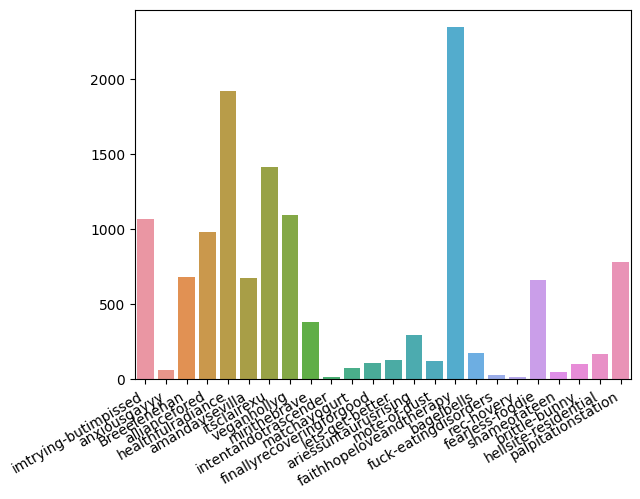

In [16]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

blog_dist = Counter(list(text_df.blog))
sns.barplot(x=list(blog_dist.keys()),y=list(blog_dist.values()))
a = plt.xticks(rotation=30,ha='right') 
# list(blog_dist.values())

In [17]:
# list(text_df[text_df.blog=='faithhopeloveandtherapy'].sample(frac=0.2).head(20).url)

Processing documens for Topicalizer

In [18]:
# text_df[['date','original_text','url']].rename(columns={'original_text':'entry','url':'Link'}).to_csv('./data/processed_ed.csv')

# Author down-sampling

down-sampling terms that are more specific to an author

In [19]:
# vocab = set()

# for tx in list(text_df.text):
#     tokens = tx.split()
#     [vocab.add(t) for t in tokens]

# with open('./data/temp_vocab_corpus.txt','w') as tfile:
#     tfile.writelines([i+'\n' for i in list(vocab)])

# print('size of dictionary is {0}'.format(len(vocab)))

In [20]:
# #storing corpus for down-sampling (we send the pre-processed docs)
# text_df[['blog','text']].to_csv('./data/temp_documents_corpus.txt',index=True,sep='\t',
#                                 header=False,encoding="UTF-8")

In [21]:
# #running down-sampling ==> if the original file in repo pops error you need to make changes in the downsample_corpus.py as stated below
# #line 68: term_means = np.mean(author_term_freqs, axis=0).ravel() 
# #line 71: term_vars = np.var(author_term_freqs, axis=0, ddof=1).ravel()
# #line 83: author_term_freqs = author_term_freqs.toarray()#added 2023,Nov
# #line 88: author_freqs = author_term_freqs[:, term_id].ravel()#.getA1() #added 2023,Nov
# !python3 ./authorless-tms/downsample_corpus.py --input ./data/temp_documents_corpus.txt --output ./data/temp_documents_corpus_new003.txt --vocab ./data/temp_vocab_corpus.txt --threshold 0.03

# loading from down-sampled dataset

In [22]:
# #updating text_df
# new_df = pd.read_csv('./data/temp_documents_corpus_new005.txt',sep='\t',header=None,
#                      names=['id','blog','text'])

# #replacing down-sampled data with original data
# for id,row in tqdm(new_df.iterrows()):
#     text_df.loc[text_df.id==id,'text'] = row['text']
#     # text_df.at[int(id),'text'] = row['text']

# #removing the ones that were deleted during down-sampling
# text_df = text_df[text_df.id.isin(new_df.id)]

# print('Number of documents after down-sampling: {0}'.format(len(text_df)))

# Running topic modeling (with or without evaluation)

In [23]:
# from rpy2.robjects.packages import importr
# utils = importr('utils')

# utils.install_packages('stm',repos="https://cloud.r-project.org")

In [10]:
is_eval = False #not evaluating the model
lon,upn = 5,31 #lowwer and upper topic number for evaluation
#need to provide number of topics and other specification
model_spec = {'name':'LDA','K':13,'epochs':3500,'burnin_iteration':150,'after_iteration_burnin':50,
             'save_flag':True,'save_path':'LDA_test','alpha_sum':30.0}#burnin_iteration=20,after_iteration_burnin=50
# model_spec = {'name':'STM','K':13,'epochs':500,'prevalence':'','content':'','pre_trained_model': 'LDA',\
#                 'burnin_iteration':150,'LDA_epochs':100,'save_flag':True}

if model_spec['name'] == 'LDA':
    if is_eval:
        #loading LDA mallet evaluation score
        from lda_mallet import lda_score
        from gensim.corpora import Dictionary
        import pickle
        from pre_processing import prepare_corpus
        #creating data vocab
        dict = Dictionary([i.split() for i in list(text_df.text)])
        #saving it to pass it to score object
        with open ('./data/ED_vocab.obj','wb') as vfile:
            pickle.dump(dict,vfile)
        wiki_vocab_dict_path = './data/wiki_sampled5p_vocab.obj'
        with open ('./data/wiki_sampled5p_vocab.obj','rb') as vfile:
            wiki_vocab_dict = pickle.load(vfile)


        npmis = []
        for n_topics in range(lon,upn,1):
            #removing terms that are not in the Wiki Vocab
            #pre_processing and tokenizing docs
            # pre_processed_docs,_ = preprocess_data(list(text_df.text),extra_stopwords=\
            #                                                set(dict.values()).difference(set(wiki_vocab_dict.values()))\
            #                                        .union(['denying']))
            pre_processed_docs,_ = preprocess_data(list(text_df.text))
            #preparing corpus
            vocab_dict,doc_term_mat = prepare_corpus(pre_processed_docs)
            #temp save of vocab file
            with open ('./data/ED_vocab.tmp','wb') as vfile:
                pickle.dump(vocab_dict,vfile)
            
            scorer = lda_score(num_topics=n_topics,alpha=10,optimize_interval=10,iterations=2000,wiki_path='./data/wiki_sampled_5p.txt',
                      db_path = './data/wiki_full/',vocab_dict_path = './data/ED_vocab.tmp', 
                      wiki_vocab_dict_path=wiki_vocab_dict_path,npmi_skip_threshold=0.30)
            
            scorer.fit(doc_term_mat)#fitting an LDA Mallet
            npmis.append([n_topics,scorer.score()])
    else: 
        #removing previously created mallet_file
        try:
            os.remove('MalletInstance_ {0}'.format(model_spec['save_path'])) 
            os.remove('MalletState_ {0} .gz'.format(model_spec['save_path']))
            os.remove('MalletSpec_ {0}'.format(model_spec['save_path']))
        except:#in case we don't have any files
            pass
        robjects.r.source('LDA_R.R')
        copy_text_df = text_df.copy()
        ans = robjects.r.findTopics(docs = copy_text_df,n_topics = model_spec['K'],epochs = model_spec['epochs'],
                                    burnin_iteration = model_spec['burnin_iteration'],
                                    after_iteration_burnin =  model_spec['after_iteration_burnin'],
                                    save_flag=model_spec['save_flag'],save_path = model_spec['save_path'],
                                    alpha_sum=model_spec['alpha_sum'])
        top_terms = np.asarray(ans[1])
        topic_doc_dist = np.asarray(ans[0][0]).T
        term_probab = ans[0][1]
        topic_vocab = ans[0][2]
        
        
elif model_spec['name'] == 'STM':
    if is_eval:
        pass
    else: 
        robjects.r.source('stm.R')
        ans = robjects.r.run_stm(docs = text_df,topic_n=model_spec['K'],max_itr=model_spec['epochs'],
                                 prevalence=model_spec['prevalence'],content=model_spec['content'],
                                 model_type = model_spec['pre_trained_model'],
                                 nits = model_spec['LDA_epochs'],burnin = model_spec['burnin_iteration'],
                                 save_flag = True)
        top_terms = np.asarray(ans[1]).reshape(model_spec['K'],50,order='F')
        topic_doc_dist = 0.00

R[write to console]: Loading required package: rJava

R[write to console]: Loading required package: mallet

R[write to console]: Loading required package: reshape2

R[write to console]: Loading required package: reticulate




    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: Loading required package: qdapTools

R[write to console]: Loading required package: reader

R[write to console]: Loading required package: NCmisc

R[write to console]: 
Attaching package: ‘reader’


R[write to console]: The following objects are masked from ‘package:NCmisc’:

    cat.path, get.ext, rmv.ext


R[write to console]: Loading required package: dplyr

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following object is masked from ‘package:qdapTools’:

    id


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: jsonlite

/usr/local/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "date". Fall back to strin

[1] "Building mallet instance ..."
[1] "Building topic trainer ..."
[1] "Loading documents in mallet instance into topic trainer ..."


Jan 09, 2024 1:24:46 PM cc.mallet.topics.ParallelTopicModel <init>
INFO: Mallet LDA: 13 topics, 4 topic bits, 1111 topic mask


[1] "Training model ..."


Jan 09, 2024 1:24:46 PM cc.mallet.topics.ParallelTopicModel initializeHistograms
INFO: max tokens: 1064
Jan 09, 2024 1:24:46 PM cc.mallet.topics.ParallelTopicModel initializeHistograms
INFO: total tokens: 672211
Jan 09, 2024 1:24:48 PM cc.mallet.topics.ParallelTopicModel estimate
INFO: <10> LL/token: -9.49362
Jan 09, 2024 1:24:48 PM cc.mallet.topics.ParallelTopicModel estimate
INFO: <20> LL/token: -9.03239
Jan 09, 2024 1:24:49 PM cc.mallet.topics.ParallelTopicModel estimate
INFO: <30> LL/token: -8.87581
Jan 09, 2024 1:24:50 PM cc.mallet.topics.ParallelTopicModel estimate
INFO: <40> LL/token: -8.80308
Jan 09, 2024 1:24:51 PM cc.mallet.topics.ParallelTopicModel estimate
INFO: 
0	2.30769	body weight health look real healthy someone 
1	2.30769	eating food eat feeling lot days control 
2	2.30769	cup chocolate butter tbsp add mix ingredients 
3	2.30769	#fitness #healthy bowl #wellness #glutenfree #foodie #healthyfood 
4	2.30769	eating help support please disorders thank grateful 
5	2.30769	e

[1] "Training complete."


Jan 09, 2024 1:29:58 PM cc.mallet.topics.ParallelTopicModel maximize
INFO: 26	67ms	0	-8.126477570591286


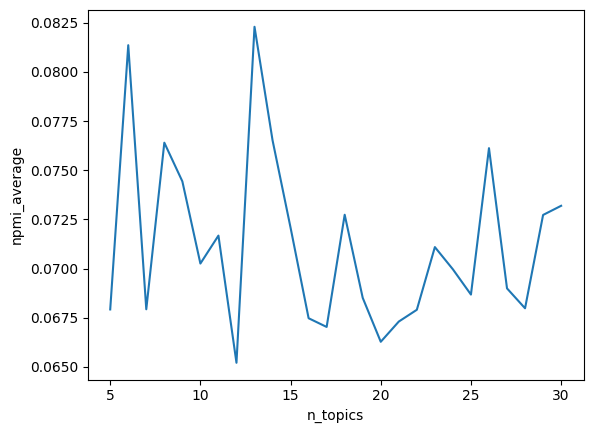

In [73]:
import seaborn as sns
df = pd.DataFrame(npmis,columns=['n_topics','npmi_average'])
sns.lineplot(data=df,x='n_topics',y='npmi_average')

df.to_csv('./result/npmi_lda.csv')

# Post-processing

topic distribution and topic selection

for topic selection I used elbow method (selecting top topics till we get to the highest gap)

In [11]:
#topic selection
topics4docs,topics4docs_bin = topic_selection(topic_doc_dist)

#topic distribution addition
for i in range(topic_doc_dist.shape[1]):
    text_df['Topic{0}_dist'.format(i)] = topic_doc_dist[:,i]
#topic selection addition
for i in range(topic_doc_dist.shape[1]):
    text_df['Topic{0}_select'.format(i)] = topics4docs_bin[:,i]

#saving data to csv
text_df.to_csv('document_topic_info.csv')

In [12]:
#storing top terms
topic_df = pd.DataFrame(data=top_terms,columns=['top_terms'])
topic_df.to_csv('topic_terms.csv')

Running Coherence

In [13]:
from lda_mallet import lda_score
import pickle

# import importlib
# importlib.reload(scorer.score_per_topic(None))

#initiate scorer
scorer = lda_score(wiki_path='./data/wiki_sampled_5p.txt',db_path='./data/wiki_full/',npmi_skip_threshold=0.25)

'''
loading wikipedia vocab to 
    1. remove the top terms that are not in the wikipedia
    2. use for gensim.coherence vocab argument in case any pairs are not in the DB
'''
with open('./data/wiki_full_vocab.obj','rb') as f: #wiki_sampled5p_vocab.obj
    scorer.wiki_vocab_dict = pickle.load(f)
    
#add all_top_terms (except the ones that are not in the wiki_pedia vocab)
scorer.all_top_terms = [[t for t in top_terms[i].split() if t in scorer.wiki_vocab_dict.token2id.keys()] for i in range(len(top_terms))]
#the output is a dictionary: the key is 0-n_topics and associated with npmi score for top-k topics 
#in which k=5,10,15,20
topic_scores = scorer.score_per_topic(None)
#getting avergae of multiple k for each topic
topic_score_avg = [np.mean([vi for ki,vi in v.items()]) for k,v in topic_scores.items()]

Load NPMI coherence DB. 
Number of keys : 1936436
skipping 0.10 missed term-pairs < allowed misses = 0.25


# soring top terms and top documents

In [14]:
show_top_doc = 10
show_top_terms = 10
file_name = 'top_documents_lda13_json.txt'

#writing the results in a text file
with open(file_name,'w') as tfile:
    for i in range(len(top_terms)):
        #writing top terms
        tfile.write('Topic '+ str(i) + ' : '+'\n'+'top terms: '+', '.join(top_terms[i].split()[:show_top_terms])+'\n')
        #selecting top documents
        top_docs = text_df.sort_values('Topic{0}_dist'.format(i),ascending=False).iloc[0:show_top_doc,:]
        for _,row in top_docs.iterrows():
            tfile.write('Doc ID: {0}, distribution: {1} ; {2} \n'.format(row.id,row['Topic{0}_dist'.format(i)],row['original_text']))
            tfile.write(''.join(['-']*60)+'\n')
        

# Storing to DB

The process is described in the code cell below

**Used the link below to insert and load blob**

https://pynative.com/python-mysql-blob-insert-retrieve-file-image-as-a-blob-in-mysql/

In [15]:
#1. save model id (for LDA save as zip and then save)
'''
2. for each topic
    3. save topic
    4. retreive the saved topic_id and save r_topic_model
    5. for each doc save r_topic_post
'''
###table format
#model: model_id, data, model_type, last_used?
# topic: topic_id, coherence, term1-50, probab1-50
#r_topic_model: topic_id, model_id 
#r_topic_post: topic_id, post_id, proportion

##check the columns of a table
# cursor.execute("show columns from r_topic_post") #execute a command
# myresult = cursor.fetchall() #get all the results 
# myresult

'\n2. for each topic\n    3. save topic\n    4. retreive the saved topic_id and save r_topic_model\n    5. for each doc save r_topic_post\n'

In [69]:
#saving the model first
#model: model_id, data, model_type, last_used?
if model_spec['name'].lower() == 'lda':
    #read binary data of the saved model
    with open('MalletState_ '+model_spec['save_path']+' .gz','rb') as model_file:
        binary_data = model_file.read()
else:
    pass #write codes for other models

#storing the model
cursor.execute(" INSERT INTO model (data, model_type) VALUES (%s,%s)",
                    (binary_data,model_spec['name']))

In [70]:
#load the model with model id to use for next steps
cursor.execute("Select * from model ORDER BY model_id DESC LIMIT 1")
result = cursor.fetchall()
model_id,model_name = result[0][0],result[0][2]

In [71]:
#saving each topic separately alongside relation to model table and post table
for k in range(0,model_spec['K']):#iterating over each topic
    #getting topic top terms
    topic_top_terms = top_terms[k].split()
    #we have to find the index in vocab (ans[0][2]) and then call ans[0][1][k][found_index] to get
    #the probability of each term
    probab = [float(term_probab[k][i]) for w in topic_top_terms for i in range(len(topic_vocab)) if w == topic_vocab[i]]
    #adding coherence score, top terms and their probabilities
    vals = tuple([float(topic_score_avg[k])]) + tuple(topic_top_terms) + tuple(probab)
    #save each topic seperately
    cursor.execute(" INSERT INTO topic(coherence,{0},{1}) VALUES (%s,{2})".format(
                                        ','.join(['term'+str(i) for i in range(1,len(topic_top_terms)+1)]),
                                        ','.join(['prob'+str(i) for i in range(1,len(topic_top_terms)+1)]),
                                        ','.join(['%s']*(len(topic_top_terms)*2))),vals)
    
    '''
    retreiving saved topic_id and save an entry for topic_id,model_id in topic_model_r table
    '''
    #load the latest stored topic
    cursor.execute("Select * from topic ORDER BY topic_id DESC LIMIT 1")
    result = cursor.fetchall()
    topic_id = result[0][0]
    #save the topic_id,model_id in r_topic_model table 
    cursor.execute(" INSERT INTO r_topic_model(topic_id,model_id) VALUES (%s,%s)",
                  (topic_id,model_id,))
    
    '''
    saving topic-document proportion for each topic-doc pairs
    '''
    #r_topic_post : topic_id, post_id, proportion
    doc_counter = 0
    for doc_id in list(text_df.id):
        cursor.execute(" INSERT INTO r_topic_post(topic_id,post_id,proportion) VALUES (%s,%s,%s)",
                  (topic_id,doc_id,float(topic_doc_dist[doc_counter,k])))
        doc_counter += 1
        

In [72]:
cnx.commit()

In [21]:
# cursor.execute("delete from r_topic_model")
# cursor.execute("delete from r_topic_post")
# cursor.execute("delete from topic")
# cursor.execute("delete from model")

# cursor.execute("select * from post")
# cursor.execute("SELECT DISTINCT user.* FROM user JOIN post ON user.user_id = post.user_id WHERE post.platform_type_id = %s",('4',))
# cursor.execute("SELECT * FROM post WHERE user_id = %s AND created BETWEEN %s AND %s;",(3,'1/1/2023','1/1/2013',))
# cursor.execute("SELECT r_topic_post.topic_id, AVG(r_topic_post.proportion) as average_proportion FROM r_topic_post JOIN r_topic_model ON r_topic_post.topic_id = r_topic_model.topic_id WHERE r_topic_post.post_id = %s AND r_topic_model.model_id = %s GROUP BY r_topic_post.topic_id;",('1187','2',))
# cursor.execute('select * from model')
cursor.fetchall()

[(11, Decimal('0.005300000')),
 (12, Decimal('0.223030000')),
 (13, Decimal('0.002400000')),
 (14, Decimal('0.007130000')),
 (15, Decimal('0.005350000')),
 (16, Decimal('0.012220000')),
 (17, Decimal('0.006210000')),
 (18, Decimal('0.005680000')),
 (19, Decimal('0.004940000')),
 (20, Decimal('0.727740000'))]

# Post-processing for Author-topic distribution

**if you are reading from DB set the from_db= True**

In [15]:
from_db = False

In [16]:
if not from_db:
    topics = [[i,topic_score_avg[i],'_'.join(top_terms[i].split()[0:3])] \
              for i in range(len(top_terms))]
else:
    #taking last topics 
    cursor.execute("select * from topic")
    topics = [list(i[0:2]) + ['_'.join(i[2:6])] for i in cursor.fetchall()[-7:]] #each topic include topic_id, coherence_score and top three terms

In [17]:
topics

[[0, 0.02503371154408084, 'body_look_photos'],
 [1, 0.13243470642303673, 'eating_food_eat'],
 [2, 0.12405380131541692, 'cup_chocolate_tbsp'],
 [3, 0.0560962401411313, '#glutenfree_#healthy_#foodie'],
 [4, 0.06229078931051387, 'eating_support_alliance'],
 [5, 0.16707396645027134, 'bowl_breakfast_cream'],
 [6, 0.0824814489322054, 'therapy_session_bit'],
 [7, 0.014645585118413787, 'guys_video_new'],
 [8, 0.010753991656784624, 'plant_free_based'],
 [9, 0.06729606733640117, 'home_last_days'],
 [10, 0.0707816420927952, 'school_trauma_treatment'],
 [11, 0.056665888074707634, 'recovery_ed_shit'],
 [12, 0.035291990916073594, 'self_take_world']]

In [18]:
#taking post_topics
if from_db:
    cursor.execute("select * from r_topic_post where topic_id between {0} and {1}".format(min(topics)[0],max(topics)[0]))
    res = cursor.fetchall() #topic_id, document_id, topic_dist
    
    doc_dist = {}
    
    for item in res:
        if item[1] not in doc_dist.keys():
            doc_dist[item[1]] = {}
        doc_dist[item[1]][item[0]] = item[2]
else:
    doc_dist = text_df.iloc[:,6:6+len(topics)].values.copy().T#topic_doc_dist.copy().T

In [19]:
#clipping doc_dist and converting to pandas DF as well
from tqdm import tqdm
from similarity import picking_topic

ddist_df = pd.DataFrame(doc_dist).T

ddist_np = ddist_df.values

for i in tqdm(range(ddist_np.shape[0])):
    ddist_np[i] = picking_topic(ddist_np[i].astype('float')) * ddist_np[i].astype('float')

100%|██████████████████████████████████| 13361/13361 [00:00<00:00, 17209.53it/s]


In [20]:
if from_db:
    ddist_df = ddist_df.rename(columns={i[0]:i[2] for i in topics})
    ddist_df['id'] = ddist_df.index
    ddist_df = ddist_df.merge(text_df[['id','blog']],on='id')
else:
    ddist_df = ddist_df.rename(columns={i[0]:i[2] for i in topics})
    ddist_df['id'] = list(text_df.id)
    ddist_df['blog'] = list(text_df.blog)

In [21]:
ddist_blog = ddist_df.groupby('blog').sum()
ddist_blog.iloc[:,0:-1] = ddist_blog.values[:,0:-1]/np.sum(ddist_blog.values[:,0:-1],axis=0)
ddist_blog

,body_look_photos,eating_food_eat,cup_chocolate_tbsp,#glutenfree_#healthy_#foodie,eating_support_alliance,bowl_breakfast_cream,therapy_session_bit,guys_video_new,plant_free_based,home_last_days,school_trauma_treatment,recovery_ed_shit,self_take_world,id
blog,,,,,,,,,,,,,,
Breeelenehan,0.539144,0.047792,0.003496,0.000000,0.001748,0.008283,0.005293,0.052270,0.273163,0.065185,0.007105,0.002321,0.036173,1820722
alliancefored,0.009505,0.004568,0.000654,0.000000,0.945270,0.000000,0.007088,0.002840,0.026572,0.013410,0.034014,0.002665,0.085218,6029796
amandavsevilla,0.019767,0.022789,0.005003,0.000679,0.002602,0.042021,0.005814,0.015993,0.163786,0.036146,0.032821,0.003807,0.181817,6074105
anxiousgayyy,0.004068,0.017751,0.000000,0.000000,0.000559,0.000622,0.001245,0.001055,0.000000,0.003006,0.000000,0.013941,0.004060,132541
ariessuntaurusrising,0.010984,0.032060,0.001121,0.000000,0.001225,0.005068,0.018869,0.006792,0.004777,0.028782,0.025826,0.064331,0.019394,4046782
bagelbells,0.012318,0.023429,0.000447,0.000000,0.001616,0.004586,0.003607,0.007488,0.010421,0.008011,0.030155,0.042226,0.014688,3125727
brittle-bunny,0.002791,0.030777,0.000000,0.000000,0.000000,0.006292,0.006065,0.000000,0.002737,0.008609,0.001618,0.017180,0.004080,2315848
faithhopeloveandtherapy,0.032410,0.112190,0.004870,0.005844,0.006166,0.111478,0.781973,0.022708,0.048153,0.319431,0.347015,0.027291,0.061495,37008505
fearless-foodie,0.026833,0.026156,0.000000,0.000000,0.005356,0.000000,0.052942,0.002786,0.021317,0.095544,0.251670,0.044670,0.069663,13375627


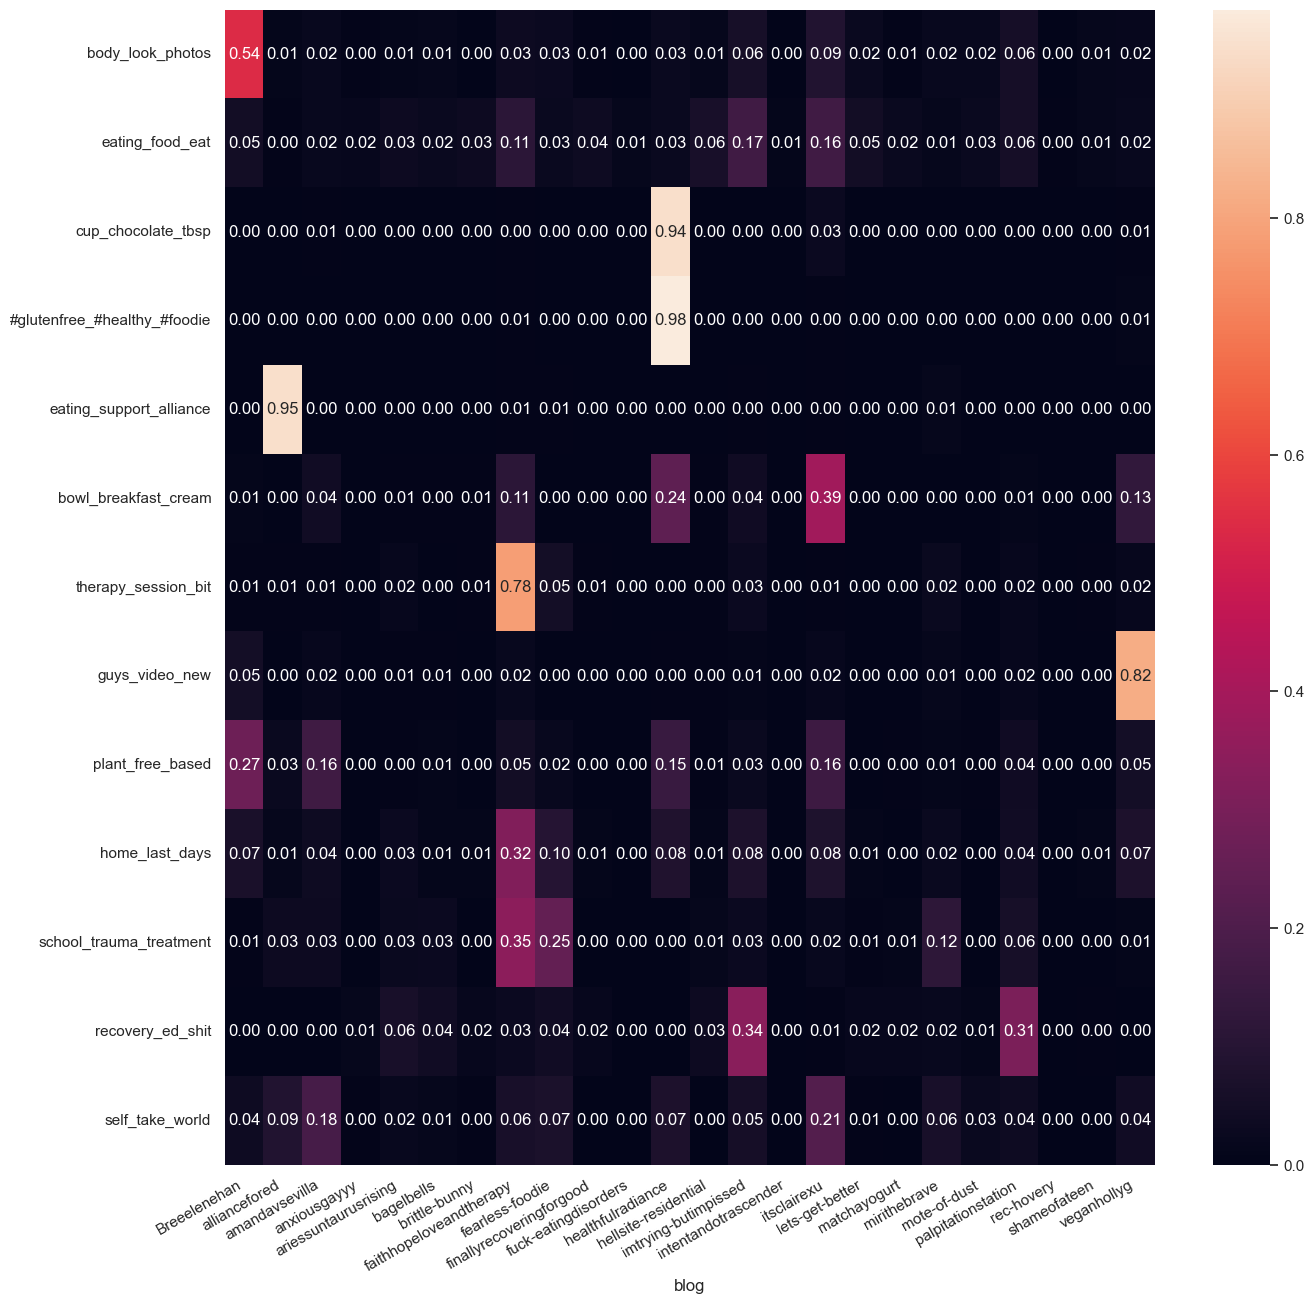

In [22]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(15,15))
sns.set(font_scale=1)
sns.heatmap(ddist_blog.iloc[:,0:-1].astype('float').T,fmt=".2f",annot=True)

plt.xticks(rotation=30,ha='right') 
plt.savefig('./result/edml/lda_nodejs.svg')
# plt.show()

In [26]:
# list(text_df[text_df.id == 16638].url)

In [106]:
topic_num = 13
top_terms_n = 10

images = [
'https://64.media.tumblr.com/332af204ee266cfdbf1be9a849e2d699/5f6ace133ce2e5e5-f2/s540x810/ff8db9c2085e9d04c65058ce8271e0ad105a7590.jpg',
    'https://64.media.tumblr.com/7c3eb313a6dd25b753a6cc343438c665/5f6ace133ce2e5e5-21/s540x810/4b6476f3c79fa594b6e163a1235e378b27e15e3b.jpg',
    'https://64.media.tumblr.com/cf932b532d59aa3640ef45c821b81422/5f6ace133ce2e5e5-34/s540x810/2b7617b910ec4955b9777c4fb9bbdca67463baef.jpg',
    'https://64.media.tumblr.com/98b723077a3f0cab8a605fdc84ad9d8d/5f6ace133ce2e5e5-a2/s540x810/6f6896b8f7eff3d04bfa078cc0e5d234933d0122.jpg',
    'https://64.media.tumblr.com/9ab30c2387b63a5cbb177911dea15af3/5f6ace133ce2e5e5-58/s540x810/f800c3fdf12b4c28d8ed5b0da0b325e9a7d0e43f.jpg',
    'https://64.media.tumblr.com/a2accc274960e3248326e52d50798723/5f6ace133ce2e5e5-f1/s540x810/e75b13fc0b891a6756ea2cbc869051328f0f4af0.jpg',
    'https://64.media.tumblr.com/2ff332757c66777e901823f2deb23718/5f6ace133ce2e5e5-46/s540x810/d941e91c9b857293929f701555c7fc07af87edc4.jpg',
    'https://64.media.tumblr.com/5b5638800fb4faf4562aed61c83e12fa/5f6ace133ce2e5e5-1d/s540x810/5f5ed129b899078359d460e674ea7484bb621fe6.jpg',
    'https://64.media.tumblr.com/4d1359668cef790289afdb2bbab4315d/5f6ace133ce2e5e5-c9/s540x810/e0229869671cc8ecdd1f1f96e43181383ae3005c.jpg',
    'https://64.media.tumblr.com/6720b01ddb9edd4e663de03c16130bbe/5f6ace133ce2e5e5-6d/s540x810/bb3d851a4efc9a08bf473e6a20da808291c61f6a.jpg',
    'https://64.media.tumblr.com/b1d4484a3c5b5fc3331e8cce9fd18441/5f6ace133ce2e5e5-79/s540x810/c0b8cfef45b6dfce5e344d48630758726eff7aa0.jpg',
    'https://64.media.tumblr.com/cf20d618399f4034b7e1a9b0e8f93ec8/5f6ace133ce2e5e5-6f/s540x810/844e6fc43919db99deb56f560fa1b429c18e2394.jpg',
    'https://64.media.tumblr.com/c46cbc67dcc86dca28b63a4c3ef070cf/5f6ace133ce2e5e5-e6/s540x810/14c8c20426fc9a9a58e017976176c92dc30f2ca0.jpg',
    'https://64.media.tumblr.com/c46cbc67dcc86dca28b63a4c3ef070cf/5f6ace133ce2e5e5-e6/s540x810/14c8c20426fc9a9a58e017976176c92dc30f2ca0.jpg',
    'https://64.media.tumblr.com/bb47980e3130cdbd56a16c013520e391/5f6ace133ce2e5e5-70/s540x810/ef684c8b04ae109c15cd15388fc0686f2315ed35.jpg',
    'https://64.media.tumblr.com/292379f3f1a61d1990857eb7b8abc216/5f6ace133ce2e5e5-64/s400x600/5b8d3562ef519805281466d96239830c01c399d7.jpg',
    'https://64.media.tumblr.com/705211a1c82e6458763314b883a09e96/180364ac42d96ec4-4b/s2048x3072/bd6d7ba23b66888de800c84824ecc15540700738.jpg',
    'https://64.media.tumblr.com/tumblr_nk60rueLFA1trg5xq_og.jpg',
    'https://64.media.tumblr.com/2d581f3936d5bfa25d08d2fa81219e89/tumblr_nqe9vanREH1trg5xqo1_400.jpg',
    
]

df = pd.DataFrame()
ls = {}

for i in range(topic_num):
    temp_df = pd.DataFrame(text_df.sort_values('Topic'+str(i)+'_dist',ascending=False).head(20)[['original_text','url']])
    temp_df['topic'] = i#topics[i][2]
    #bold the terms in top terms
    topic_top_terms = top_terms[i].split()[0:top_terms_n]
    temp_df['top_terms'] = '_'.join(topic_top_terms)
    texts = list(temp_df['original_text'])
    for j in range(len(texts)):
        for term in topic_top_terms:
            texts[j] = texts[j].replace(term,'<b>{0}</b>'.format(term))
    temp_df['original_text'] = texts
    df = pd.concat([temp_df,df])
    ls['topic {0}'.format(i)] = [[a,b,c,np.random.choice(images)] for a,b,c in \
                                             zip(list(temp_df['top_terms']),texts,\
                                                              list(temp_df['url']))]


import json

obj = json.dumps(ls)

with open('./data/topics.json','w') as f:
    f.write(obj)

df['photo'] = 'NA'

df.iloc[-1].original_text,df.iloc[-1].top_terms

('emjaydee: \n\n kiribird: \n\nme: all <b>bodies</b> are beautiful. \nmy brain: yes. \nme: so, my <b>body</b> is also beautiful. \nmy brain: absolutely not??? nO??? \n\n THIS',
 'body_look_photos_real_happy_skin_bodies_self_image_wear')

In [24]:
df.to_csv('./data/topics_ed_visualization.csv')

In [25]:
#converting to date format
text_df.date = pd.to_datetime(text_df.date)
days = date2days(text_df)
days

,id,text,original_text,date,url,blog,Topic0_dist,Topic1_dist,Topic2_dist,Topic3_dist,...,Topic4_select,Topic5_select,Topic6_select,Topic7_select,Topic8_select,Topic9_select,Topic10_select,Topic11_select,Topic12_select,days
8880,14008,spotify came personalized summer rewind playli...,Spotify just came out with their personalized ...,2019-06-25 18:18:31+00:00,https://ariessuntaurusrising.tumblr.com/post/1...,ariessuntaurusrising,0.002454,0.007700,0.001870,0.001823,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
8879,14007,kinda wanna hurt currently broke pierced tatto...,I really just kinda wanna do something that wi...,2019-06-25 18:41:40+00:00,https://ariessuntaurusrising.tumblr.com/post/1...,ariessuntaurusrising,0.003753,0.011773,0.002860,0.002788,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
8878,14006,depression nap body trying cope eaten mystery ...,is it depression nap time or is my body trying...,2019-06-25 20:05:36+00:00,https://ariessuntaurusrising.tumblr.com/post/1...,ariessuntaurusrising,0.004556,0.656561,0.003472,0.003385,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8877,14005,keep portion sizes small live smaller,you know what i always say! keep my portion si...,2019-06-26 00:06:53+00:00,https://ariessuntaurusrising.tumblr.com/post/1...,ariessuntaurusrising,0.005797,0.835415,0.004418,0.004307,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8876,14003,nothing world ever able hate intimately,there is nothing in this world that you will e...,2019-06-26 01:12:40+00:00,https://ariessuntaurusrising.tumblr.com/post/1...,ariessuntaurusrising,0.005797,0.018188,0.004418,0.004307,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11640,18442,efforts decrease stigma centered around depres...,if your efforts to decrease stigma are centere...,2020-12-05 20:20:23+00:00,https://fearless-foodie.tumblr.com/post/636694...,fearless-foodie,0.001823,0.005721,0.001389,0.001355,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,520
11639,18438,deal seeing patients come hard form connection...,Question: How do you deal with seeing other pa...,2020-12-06 20:15:35+00:00,https://fearless-foodie.tumblr.com/post/636785...,fearless-foodie,0.000642,0.002013,0.000489,0.000477,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,521
11638,18434,thing ordered fast food fear foods ate kitchen...,i did a thing! i ordered fast food (one of my ...,2020-12-07 22:53:24+00:00,https://fearless-foodie.tumblr.com/post/636885...,fearless-foodie,0.001905,0.677361,0.001452,0.001415,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,522
11637,18431,hard panic attacks dissociative symptoms recen...,today's been a hard day. i've been having more...,2020-12-09 03:37:16+00:00,https://fearless-foodie.tumblr.com/post/636994...,fearless-foodie,0.001140,0.512388,0.000869,0.000847,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,523


In [27]:
#topic transitions
from post_processing import transition_analysis

res = transition_analysis(days,n_topics=model_spec['K'],begin_col=6,end_col=6+model_spec['K'])


100%|███████████████████████████████████████████| 24/24 [00:26<00:00,  1.11s/it]


In [37]:
res['use'][0][0].shape[0]

13

0.10480374461414932

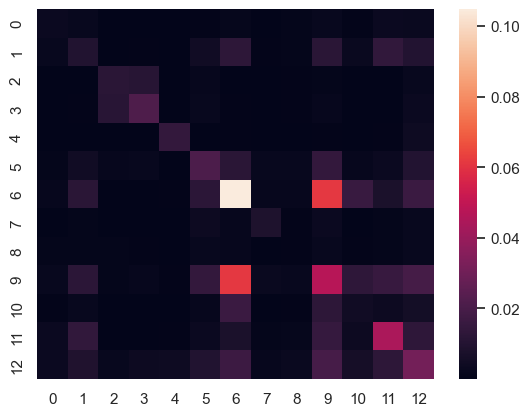

In [55]:
import seaborn as sns
# from post_processing import trns2mat

mat = trns2mat(res['use'])
sns.heatmap(mat/np.sum(mat))
np.max(mat/np.sum(mat))

In [87]:
#get top three topics for each topic
top_pick = 3
ls = {}
for i in range(mat.shape[0]):
    row = mat[i]
    trns = np.sort(row)[-top_pick:][::-1]
    idx = np.argsort(row)[-top_pick:][::-1]
    ls['topic {0}'.format(i)] = [[int(a),float(b)] for a,b in zip(list(idx),list(trns/np.sum(trns)))]

import json

obj = json.dumps(ls)

with open('./data/topic_transitions.json','w') as f:
    f.write(obj)

In [206]:
import math, datetime
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

dataf_rnorm = robjects.DataFrame(ddist_blog.iloc[:,0:-1])
robjects.r(''' 
library(data.table)
topic.title.tall <- melt(setDT(ddist_blog), id.vars = c("title"), variable.name = "topic")
''')

KeyError: <class 'float'>

In [198]:
from plotnine import ggplot, aes, geom_line,geom_tile, scale_fill_gradient
(
ggplot(ddist_blog.iloc[:,0:-1], aes(x='blog')) +
    # geom_tile(aes(fill = value)) + 
    # geom_text(aes(label = round(value, 2))) +
    scale_fill_gradient(low = "white", high = "red")
    # +theme(text = element_text(size=20),axis.text.x = element_text(angle=45, hjust=1))
)

PlotnineError: "Could not evaluate the 'x' mapping: 'blog' (original error: name 'blog' is not defined)"

In [199]:
ddist_blog

,eating_support_alliance_us,bowl_oats_butter_almond,life_body_feel_like,roasted_#healthy_oil_add,body_like_feel_day,day_time_one_like,cup_chocolate_butter_add,id
blog,,,,,,,,
Breeelenehan,0.004505,0.011943,0.032642,0.002196,0.805447,0.123988,0.006482,1873399
alliancefored,0.901694,0.000727,0.074312,0.0,0.035109,0.021241,0.000715,6127291
amandavsevilla,0.009553,0.019371,0.158634,0.015112,0.018207,0.11161,0.005156,6136628
anxiousgayyy,0.000502,0.0,0.020532,0.000634,0.002199,0.002959,0.0,132541
healthfulradiance,0.009095,0.587512,0.09613,0.699153,0.027373,0.112608,0.944535,14710522
imtrying-butimpissed,0.024045,0.015182,0.285263,0.004865,0.031289,0.040838,0.0,1490061
itsclairexu,0.036686,0.293368,0.30226,0.09059,0.05645,0.139927,0.03727,14539093
veganhollyg,0.013919,0.071898,0.030227,0.187451,0.023927,0.446829,0.005842,12825333
